In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def extract_embeddings_to_df(data):
    embeddings = [item['embedding'] for item in data if 'embedding' in item]
    df = pd.DataFrame(embeddings)
    return df


In [4]:
with open("/mnt/petrelfs/hujucheng/SFT_tools/SFT_toolkit/data/embeddings_of_test/hu_MCQ_logiqa.json","r") as input_embedding:
    test_dict = json.load(input_embedding)
with open("/mnt/petrelfs/hujucheng/SFT_tools/SFT_toolkit/data/embeddings_of_train/hu_SFT_data_for_LogiQA_from_LogiQAofficial_Train_3000.json","r") as input_embedding:
    train_dict = json.load(input_embedding)
test_df = extract_embeddings_to_df(test_dict)
train_df = extract_embeddings_to_df(train_dict)

In [5]:


def plot_pca_3d(df1, df2):
    # Initialize PCA
    pca = PCA(n_components=3)
    
    # Fit and transform both dataframes
    reduced_data1 = pca.fit_transform(df1)
    reduced_data2 = pca.fit_transform(df2)
    
    # Plot the reduced data in 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot for the first dataframe
    ax.scatter(reduced_data1[:, 0], reduced_data1[:, 1], reduced_data1[:, 2], 
               alpha=0.7, color='b', label='Test')
    
    # Scatter plot for the second dataframe
    ax.scatter(reduced_data2[:, 0], reduced_data2[:, 1], reduced_data2[:, 2], 
               alpha=0.7, color='r', label='Train')
    
    # Set plot titles and labels
    ax.set_title('3D PCA of Embeddings')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    
    # Add legend
    ax.legend()
    
    # Show plot
    plt.show()


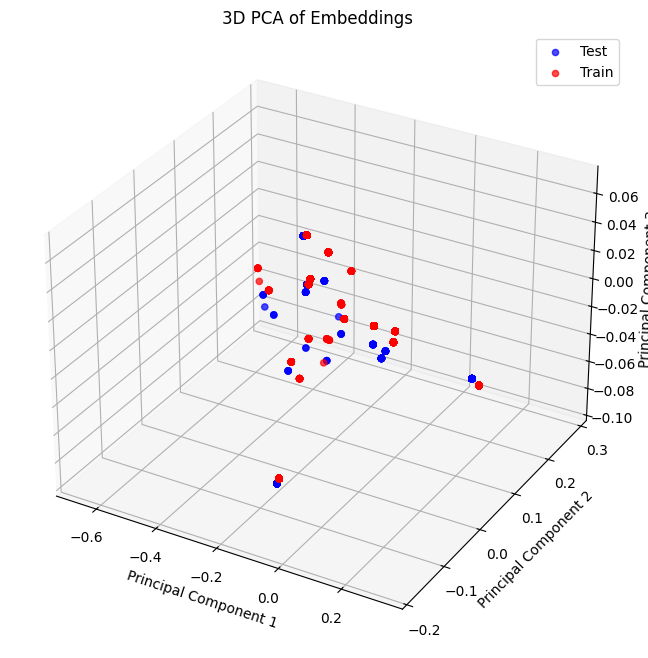

In [6]:
plot_pca_3d(test_df,train_df)

In [7]:
def filter_by_absolute_distance(test_df, train_df, distance_threshold):
    pca = PCA(n_components=3)
    
    # Fit and transform both dataframes
    reduced_data1 = pca.fit_transform(test_df)
    reduced_data2 = pca.fit_transform(train_df)    
    distances = pairwise_distances(reduced_data2, reduced_data1)
    
    min_distances = np.abs(distances).min(axis=1)
    
    # Filter df2 based on the distance threshold
    filtered_df2 = train_df[min_distances > distance_threshold]
    
    return filtered_df2

# Example usage:
# filtered_df2 = filter_by_absolute_distance(test_df, train_df, distance_threshold=0.11)
# filtered_df2

In [8]:
def compute_cos_similarity_with_cores(selection_df, reference_df, n_clusters):
    # Cluster the reference embeddings
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reference_df)
    centroids = kmeans.cluster_centers_
    
    # Compute similarity of each selection embedding to each cluster centroid
    similarity_matrix = cosine_similarity(selection_df, centroids)
    
    # Take the maximum similarity for each selection embedding
    max_similarities = similarity_matrix.max(axis=1)
    
    return max_similarities



In [9]:

n_clusters = 8
max_similarities = compute_cos_similarity_with_cores(train_df, test_df, n_clusters)
max_similarities.std()


3.570620343696425e-08

In [10]:
def compute_similarity_with_cores(selection_df, reference_df, n_clusters):
    # # Normalize embeddings
    # selection_df = selection_df.apply(lambda x: x / np.linalg.norm(x), axis=1)
    # reference_df = reference_df.apply(lambda x: x / np.linalg.norm(x), axis=1)
    
    # Dimensionality reduction
    pca = PCA(n_components=50)  # Adjust components based on variance explained
    reference_df_reduced = pca.fit_transform(reference_df)
    selection_df_reduced = pca.transform(selection_df)
    
    # Cluster the reduced reference embeddings
    n_clusters = min(n_clusters, len(reference_df_reduced))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reference_df_reduced)
    centroids = kmeans.cluster_centers_
    
    # Compute similarity of each selection embedding to each cluster centroid
    similarity_matrix = cosine_similarity(selection_df_reduced, centroids)
    
    # Take the maximum similarity for each selection embedding
    max_similarities = similarity_matrix.max(axis=1)
    
    return max_similarities


In [11]:
max_similarities = compute_similarity_with_cores(train_df, test_df, n_clusters)
max_similarities.std()

0.04170909109632214

In [13]:
def filter_top_20_percent(json_data, similarities,abandon_ration):
    threshold = np.percentile(similarities, abandon_ration*100)

    filtered_data = [json_data[i] for i in range(len(similarities)) if similarities[i] >= threshold]
    
    return filtered_data

In [14]:
filtered_json_data = filter_top_20_percent(train_dict, max_similarities,0.999)

In [15]:
len(filtered_json_data)

814

In [16]:
for i in filtered_json_data:
    del i["embedding"]

In [17]:
with open("/mnt/petrelfs/hujucheng/SFT_tools/SFT_toolkit/data/LogiQA/hu_SFT_data_for_LogiQA_from_LogiQAofficial_Train_3000_of_814_raw_selected.json", 'w') as json_file:
    json.dump(filtered_json_data, json_file, indent=4, ensure_ascii=False)